In [1]:
#importing lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

In [54]:
#setting date column as index
df=pd.read_csv(r"X:\Project\TSA\TSA\RELIANCE.NS.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date',inplace=True)
del df['Adj Close']


In [55]:
df.shape

(2024, 5)

In [175]:
#plotting candlestick plot 
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df.index,
                       open=df.Open, high=df.High,
                       low=df.Low, close=df.Close)])

fig.show()


In [185]:
#calculating moving average
Moving_Average_Day = [50, 100, 200]
for Moving_Average in Moving_Average_Day:
  for company in df:
    column_name = f'Moving Average for {Moving_Average} days'
    df[column_name] = df["Close"].rolling(Moving_Average).mean()

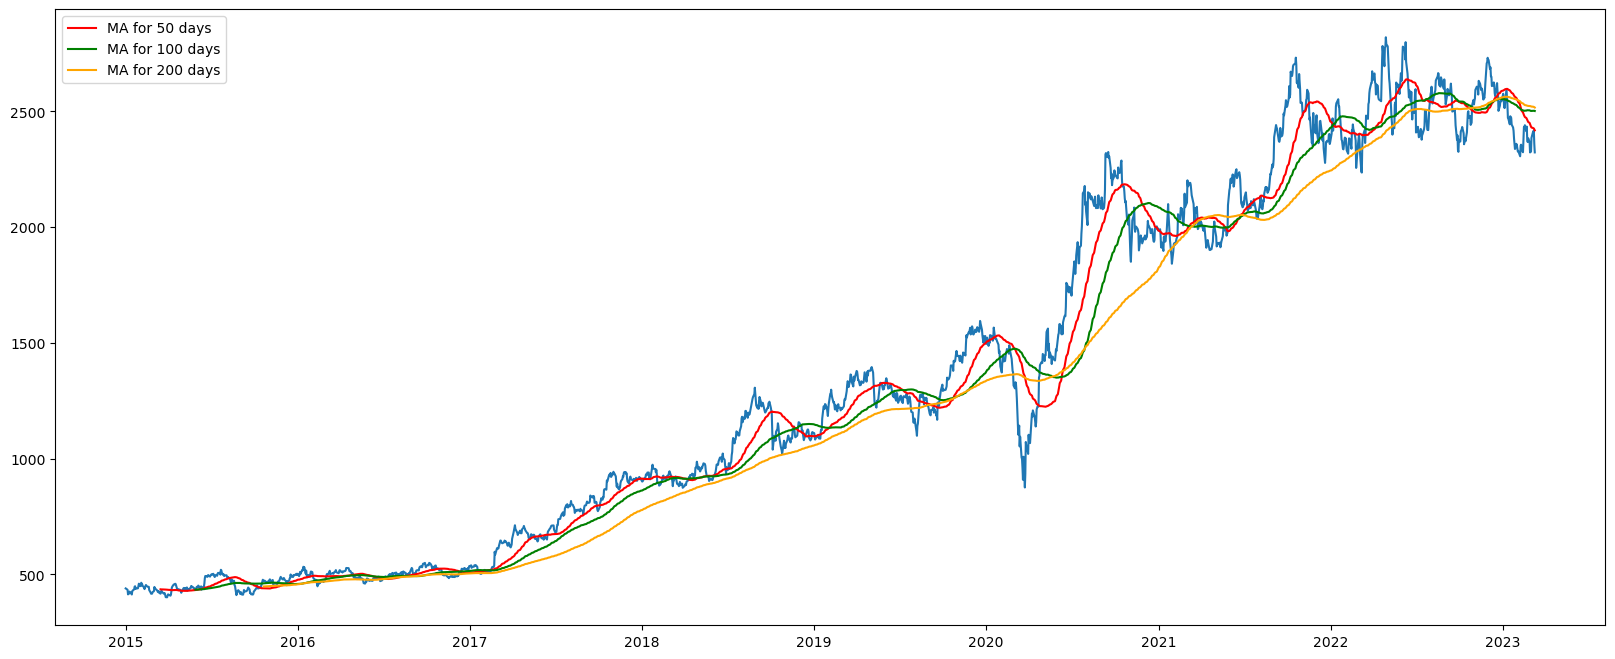

In [199]:
#plotting moving average
plt.figure(figsize=(20,8))
plt.plot(df.index, df["Close"])
plt.plot(df.index, df["Moving Average for 50 days"],color='red',label='MA for 50 days')
plt.plot(df.index, df["Moving Average for 100 days"],color='green',label='MA for 100 days')
plt.plot(df.index, df["Moving Average for 200 days"],color='orange',label='MA for 200 days')
plt.legend()

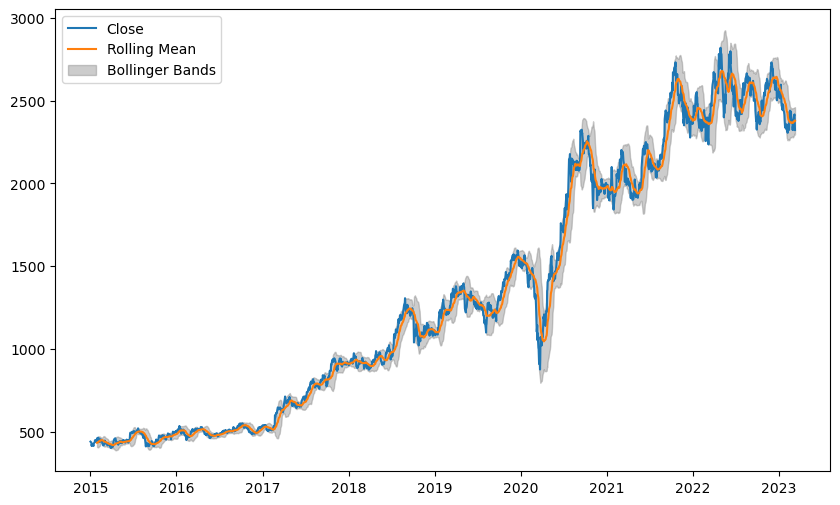

In [193]:
#plotting bollinger band
rolling_mean = df['Close'].rolling(window=20).mean()
rolling_std = df['Close'].rolling(window=20).std()
upper_band = rolling_mean + (rolling_std * 2)
lower_band = rolling_mean - (rolling_std * 2)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df.index, df['Close'], label='Close')
ax.plot(rolling_mean.index, rolling_mean, label='Rolling Mean')
ax.fill_between(rolling_mean.index, upper_band, lower_band, alpha=0.4, color='gray', label='Bollinger Bands')
ax.legend()
plt.show()

In [56]:
#scaling data
scaler = StandardScaler()
scaler = scaler.fit(df)
df_s = scaler.transform(df)
len(df_s)
window_size=7

In [57]:
#splitting data into train and test dataset
train_size = int(len(df_s) * 0.8)
train_data = df_s[:train_size]
test_data = df_s[train_size-window_size:]

In [58]:
#function for window size
def df_to_x_y(data, window_size=7):
  
  X = []
  y = []
  for i in range(len(data)-window_size):
    row = [r for r in data[i:i+window_size]]
    X.append(row)
    label = [data[i+window_size][3]]
    y.append(label)
  return np.array(X), np.array(y)

In [59]:
x_train,y_train = df_to_x_y(train_data)
x_test,y_test=df_to_x_y(test_data)


In [60]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [253]:
#CNN-LSTM model
model = Sequential()


model.add(Conv1D(filters=256, kernel_size= 1, activation='relu', input_shape=(x_train.shape[1],x_train.shape[2])))
#model.add(Conv1D(filters=128, kernel_size= 1,  activation='relu'))
model.add(MaxPooling1D(pool_size=5, padding='valid'))
model.add(Conv1D(filters=64,  kernel_size= 1, activation='relu'))

model.add(LSTM(units=100, return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(units=75, return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))

model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

model.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 7, 256)            1536      
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 1, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_31 (Conv1D)          (None, 1, 64)             16448     
                                                                 
 lstm_48 (LSTM)              (None, 1, 100)            66000     
                                                                 
 lstm_49 (LSTM)              (None, 1, 75)             52800     
                                                                 
 lstm_50 (LSTM)              (None, 1, 50)             25200     
                                                     

In [255]:

history=model.fit(x_train, y_train, epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
51/51 [==============================] - 6s 115ms/step - loss: 0.2435 - val_loss: 0.2636
Epoch 2/10
51/51 [==============================] - 2s 32ms/step - loss: 0.0121 - val_loss: 0.1253
Epoch 3/10
51/51 [==============================] - 3s 68ms/step - loss: 0.0053 - val_loss: 0.1218
Epoch 4/10
51/51 [==============================] - 4s 81ms/step - loss: 0.0045 - val_loss: 0.1130
Epoch 5/10
51/51 [==============================] - 4s 85ms/step - loss: 0.0046 - val_loss: 0.1274
Epoch 6/10
51/51 [==============================] - 4s 81ms/step - loss: 0.0046 - val_loss: 0.1190
Epoch 7/10
51/51 [==============================] - 4s 82ms/step - loss: 0.0045 - val_loss: 0.1091
Epoch 8/10
51/51 [==============================] - 4s 85ms/step - loss: 0.0044 - val_loss: 0.1139
Epoch 9/10
51/51 [==============================] - 4s 80ms/step - loss: 0.0040 - val_loss: 0.0868
Epoch 10/10
51/51 [==============================] - 4s 82ms/step - loss: 0.0040 - val_loss: 0.0821


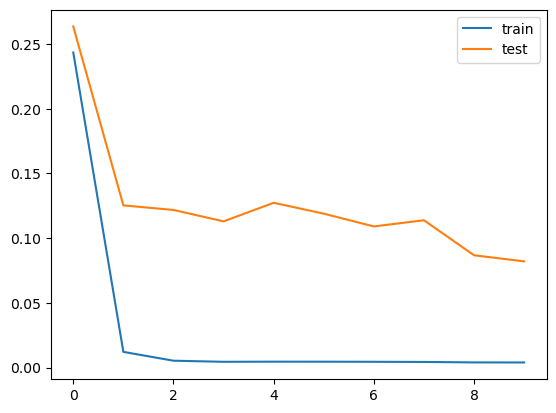

In [256]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [257]:

yhat=model.predict(x_test)


13/13 [==============================] - 3s 10ms/step


In [258]:
yp=yhat.reshape(yhat.shape[0],1)
len(yp)

405

In [259]:
test_RMSE= np.sqrt(mean_squared_error(y_test, yp))
test_MAE= mean_squared_error(y_test, yp )

In [260]:
print(f"Test RMSE: {test_RMSE}")
print(f"Test MAE: {test_MAE}")

Test RMSE: 0.2865181317752895
Test MAE: 0.08209263983600218


In [261]:
# create empty table with 12 fields
trainPredict_dataset_like = np.zeros(shape=(len(yp), 5) )
# put the predicted values in the right field
trainPredict_dataset_like[:,0] = yp[:,0]
# inverse transform and then select the right field
trainPredict = scaler.inverse_transform(trainPredict_dataset_like)[:,0]



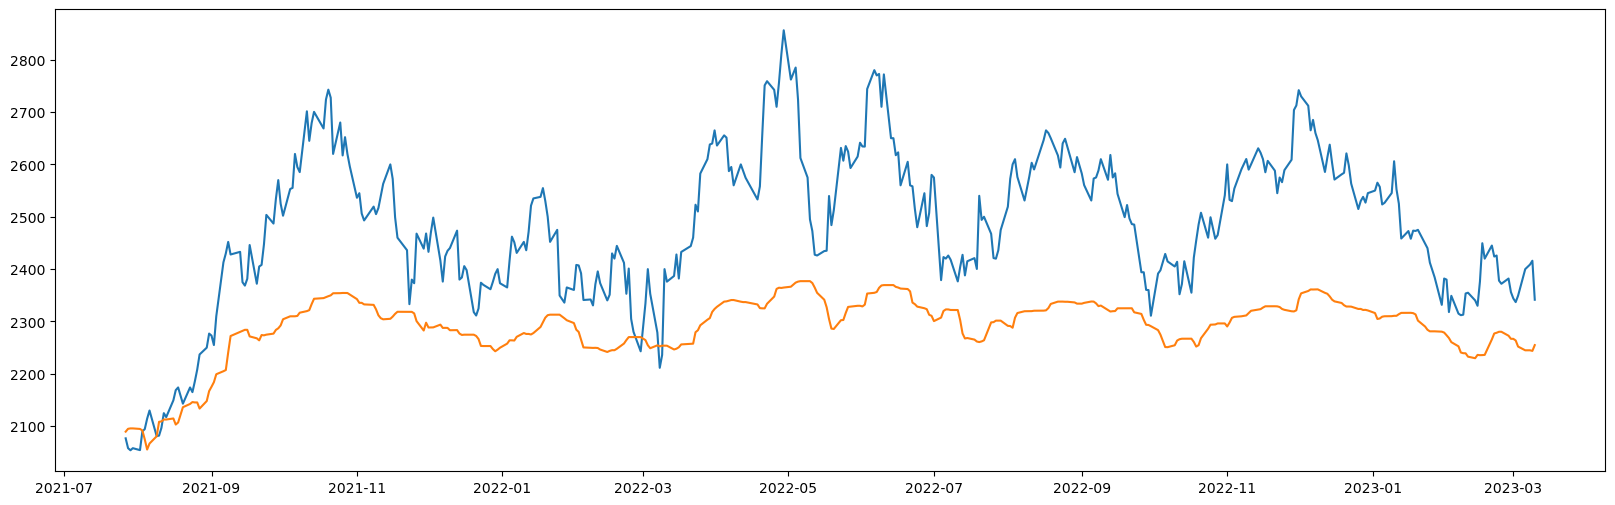

In [262]:
plt.figure(figsize=(20,6))
plt.plot(df.index[train_size:],df.iloc[train_size:,0], label='Actual')
plt.plot(df.index[train_size:],trainPredict, label='Actual')

plt.show()

In [252]:
from sklearn.metrics import mean_squared_error, mean_absolute_error